### Problem 1 - Normalized Mutual Info

In [1293]:
from sklearn.metrics.cluster import normalized_mutual_info_score

y_true = [1,1,1,2,2,2,2,2,1,1,1,1,1,1] #class labels
y_pred = [1,1,1,1,1,1,2,2,2,2,2,2,2,2] #clustering assignments
print(f'NMI: {normalized_mutual_info_score(y_true,y_pred):.2f}')

NMI: 0.05


### Problem 3 - Community Detection (25 pts)

Read about Zachary's Karate Club Problem and download the adjacency
matrix for this problem from: http://networkdata.ics.uci.edu/data/karate/
and obtain the correct community assignments from Table 1 (column: club
after fission) in the original paper: http://aris.ss.uci.edu/lin/76.pdf


- Perform spectral clustering for k=2 and report the 2 communities and the
F-measure. Submit your code and instructions for running it.
- Perform modularity maximization for k=2 and report the 2 communities
and the F-measure. Submit your code and instructions for running it.

In [1268]:
#Load Data
import numpy as np
import networkx as nx
import sys
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

path = os.getcwd() + "\\karate\\karate.paj"  #datda path
nodes = [i + 1 for i in range(34)]  #node list
edges = np.loadtxt(path, 'int')[34:]  #edge list as str

print(f'Nodes: {len(nodes)}')  #should be 34
print(f'Edges: {len(edges)}')  #should be 78

y_true = np.array((1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
                   0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))

assert len(y_true[y_true == 1]) & len(
    y_true[y_true == 0]) == 17, 'invalid labels provided'

Nodes: 34
Edges: 78


visualizing Graph Structure
--------------------------------------------------


C:\Users\jdine\AppData\Roaming\Python\Python37\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


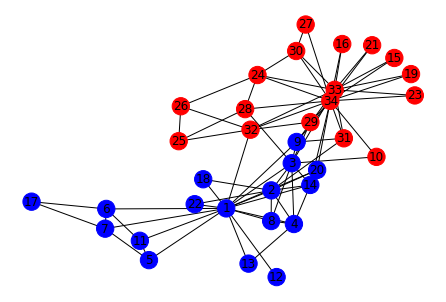

In [1146]:
import matplotlib.pyplot as plt
G = nx.Graph()

[G.add_node(i) for i in nodes]
assert len(G.nodes) == len(nodes), 'Nodes not added correctly'
[G.add_edge(*i) for i in edges]  #star op unpacks tuples
assert len(G.edges) == len(edges), 'Edges not added correctly'

print('visualizing Graph Structure')
print('-' * 50)

#Color Nodes in visual
color_map = []
for i in G:
    if y_true[i - 1] == 1:
        color_map.append('blue')
    else:
        color_map.append('red')

nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

#This is the same as G = nx.karate_club_graph()

In [1272]:
print('Printing Adj Matrix')
print('-' * 100)
adj_mat = nx.adjacency_matrix(G).toarray()
#Matches p.457 from  An Information Flow Model for Conflict and Fission in Small Groups
print(adj_mat)

Printing Adj Matrix
----------------------------------------------------------------------------------------------------
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


#### Perform spectral clustering for k=2 and report the 2 communities and the F-measure. Submit your code and instructions for running it.

#### Using Fiedler Vector

In [1275]:
# Get Degree Matrix
# diag(D) corresponds to the degrees of each node in the graph
D = np.diag(np.sum(np.array(adj_mat), axis=1))

#Get Laplacian Matrix
L = D - adj_mat
print(L)

#check against NXd
if np.allclose(L, nx.laplacian_matrix(G).toarray()):
    print('laplacian successfully computed')

##f the graph (W) has K connected components, then L has K eigenvectors with an eigenvalue of 0.
print(f'G has {connected_comps} connected components')

[[16 -1 -1 ... -1  0  0]
 [-1  9 -1 ...  0  0  0]
 [-1 -1 10 ...  0 -1  0]
 ...
 [-1  0  0 ...  6 -1 -1]
 [ 0  0 -1 ... -1 12 -1]
 [ 0  0  0 ... -1 -1 17]]
laplacian successfully computed
G has 1 connected components


In [1276]:
def class_report(y_true, y_hat):
    '''
    Parms:
        cm: 2x2 array (binary classification), confusion matrix
    Returns
        Classification Report
                Confusion Matrix
                ----------------
                TP FP
                FN TN

                Precision: TP/ TP + FP
                Recall: TP / TP+FN
                F1: 2 * ((P * R)/ (P + R))

    '''
    num_correct = sum(y_true == y_hat)
    total = len(G.nodes)
    accuracy = num_correct / total

    cm = confusion_matrix(y_true, y_hat)
    precision = sklearn.metrics.precision_score(y_true, y_hat)
    recall = sklearn.metrics.recall_score(y_true, y_hat)
    f1 = sklearn.metrics.f1_score(y_true, y_hat)
    print(
        f'Accuracy {accuracy:.2f}% \nPrecision {precision:.2f}% \nRecall {recall:.2f}% \nF1 Score {f1:.2f}%'
    )

    print('-' * 50)
    print(f'Community: Mr. Hi {np.where(y_hat == 1)}')
    print('-' * 50)
    print(f'Community: Officers {np.where(y_hat == 0)}')

    return precision, recall, f1, accuracy


def simple_plot(metrics, metric):
    if metric == 'precision':
        x = 0
    elif metric == 'recall':
        x = 1
    elif metric == 'f1':
        x = 2
    else:
        x = 3
    plt.scatter([i for i in range(34)], [i[x] for i in metrics])
    plt.title(f'{metric} for various eigenvectors')
    plt.show()

In [1255]:
#We want to take the second smallest eigenvalue,vector pair from the laplacian
#https://towardsdatascience.com/spectral-clustering-aba2640c0d5b
#The Fiedler value approximates the minimum graph cut needed to separate the graph into two connected components.
#This may actual be the spectal gap. I'm unsure if you count the ~0 eigenvalue here. Results would indicate that the below is correct
#we have 1 connected component, so 1 0 (approx) eigenvalue

# eigenvalues and eigenvectors
e, v = np.linalg.eig(L)

# sort these based on the eigenvalues
v = v[:, np.argsort(e)]
e = e[np.argsort(e)]

metrics = []
for i in [1]:
    y_hat = v[:, i]
    y_hat[y_hat < 0] = 0
    y_hat[y_hat > 0] = 1
    precision, recall, f1, accuracy = class_report(y_true, y_hat)
    metrics.append((precision, recall, f1, accuracy))

# precision, recall, f1, accuracy = metrics[1]  #extract metrics for Fiedler value
print('Using Fiedler Vector')
print('-' * 50)

Accuracy 0.94% 
Precision 1.00% 
Recall 0.88% 
F1 Score 0.94%
--------------------------------------------------
Community: Mr. Hi (array([ 0,  1,  3,  4,  5,  6,  7, 10, 11, 12, 13, 16, 17, 19, 21],
      dtype=int64),)
--------------------------------------------------
Community: Officers (array([ 2,  8,  9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33], dtype=int64),)
Using Fiedler Vector
--------------------------------------------------


Showing Fiedler Value vs all other eigenvectors


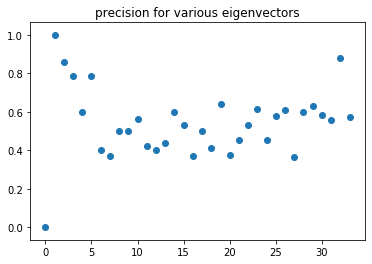

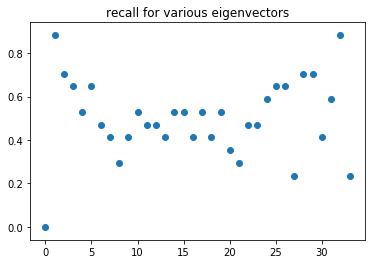

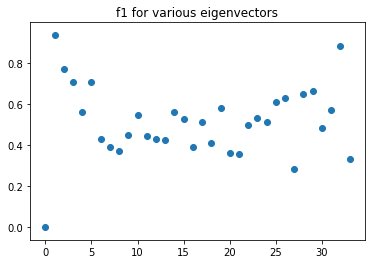

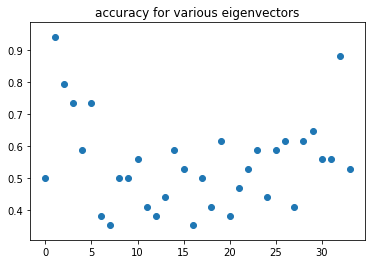

In [1243]:
print('Showing Fiedler Value vs all other eigenvectors')
simple_plot(metrics, metric='precision')
simple_plot(metrics, metric='recall')
simple_plot(metrics, metric='f1')
simple_plot(metrics, metric='accuracy')

#### Using Kmeans on two smallest eigenvalues vectors

In [1257]:
print('From Scratch building Laplacian')
print('-' * 100)
model = sklearn.cluster.KMeans(n_clusters=2, random_state=2, max_iter= 100)
y_hat = model.fit(v[:, 1:2]).labels_
precision, recall, f1, accuracy = class_report(y_true, y_hat)


From Scratch building Laplacian
----------------------------------------------------------------------------------------------------
Accuracy 0.94% 
Precision 1.00% 
Recall 0.88% 
F1 Score 0.94%
--------------------------------------------------
Community: Mr. Hi (array([ 0,  1,  3,  4,  5,  6,  7, 10, 11, 12, 13, 16, 17, 19, 21],
      dtype=int64),)
--------------------------------------------------
Community: Officers (array([ 2,  8,  9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33], dtype=int64),)


In [1258]:
from sklearn.cluster import SpectralClustering
print('Validating with sklearn spectral clustering')
print('-' * 100)
model = SpectralClustering(2, random_state= 2)
y_hat = model.fit(adj_mat).labels_
print_logs()

Validating with sklearn spectral clustering
----------------------------------------------------------------------------------------------------
Accuracy 0.94% 
Precision 1.00% 
Recall 0.88% 
F1 Score 0.94%
--------------------------------------------------
Community: Mr. Hi (array([ 0,  1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 16, 17, 19, 21],
      dtype=int64),)
--------------------------------------------------
Community: Officers (array([ 8,  9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33], dtype=int64),)


C:\Users\jdine\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


#### Perform modularity maximization for k=2 and report the 2 communities and the F-measure. Submit your code and instructions for running it.

In [1283]:
B = nx.linalg.modularity_matrix(G) # Mod Matrix: B = A - DD^T / 2m 


# eigenvalues and eigenvectors
vals, vectors = np.linalg.eig(B)
v = vectors.real #get read
e = vals.real 


v = np.concatenate(v) #flatten array for sklearn

print('From Scratch building Mod Matrix')
print('-' * 100)
print('max eigenvalue indices:', sorted(np.argsort(e)[-2:])) #2 communities / 2 largest eigenvectors

model = sklearn.cluster.KMeans(n_clusters=2, random_state=2)
y_hat = model.fit(v[:, 1:2]).labels_
precision, recall, f1, accuracy = class_report(y_true, y_hat)


From Scratch building Mod Matrix
----------------------------------------------------------------------------------------------------
max eigenvalue indices: [1, 2]
Accuracy 0.97% 
Precision 1.00% 
Recall 0.94% 
F1 Score 0.97%
--------------------------------------------------
Community: Mr. Hi (array([ 0,  1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 16, 17, 19, 21],
      dtype=int64),)
--------------------------------------------------
Community: Officers (array([ 8,  9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33], dtype=int64),)


### Problem 4 - Recommendation (25 pts)
Implement a movie rating prediction program for both item-based and user-
based collaborative filtering for the Movielens 100k dataset available at
http://grouplens.org/datasets/movielens/

Your program must take as input a user-item matrix (same format as u.data),
the neighborhood size, a user id 'u', and an item-id 'i' and should provide the
predicted rating for both user-based CF and item-based CF as output.

#### Here are brief descriptions of the data.

ml-data.tar.gz   -- Compressed tar file.  To rebuild the u data files do this:
                gunzip ml-data.tar.gz
                tar xvf ml-data.tar
                mku.sh

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.



In [21]:
#Merge Data
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from itertools import islice


class dataLoader(object):
    #-----------------------------------------------------------------------------------------------#
    '''
    Data Loading and Cleaning Tool for MovieLens 100k Dataset

    PARMS:
        path: Specify path top data directory
        init contains all column naming conventions to be used in df generation


    RETURNS:
        A single dataframe object merging source data from user_ratings / user_meta / item_meta
            - Drop Unnecessary temporal columns
                - Timestamp 
                - Release Date (Extract Year for Year-Diff in similarity comp)
            - Get Dummies for Features:
                - Gender / Occupation
                    -Used for user similarity calc?
        REVISION: Leave as separate DFs for easier column indexing. May merge later
    '''

    #-----------------------------------------------------------------------------------------------#
    def __init__(self, path):
        self.path = os.getcwd() + '\\movieLens_data'
        self.encoding = "iso-8859-1"
        self.user_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
        self.item_cols = [
            "movie_id", "movie_title", "release_date", "video_release_date",
            "IMDb_URL", "genre_unknown", "genre_Action", "genre_Adventure",
            "genre_Animation", "genre_Childrens", "genre_Comedy",
            "genre_Crime", "genre_Documentary", "genre_Drama", "genre_Fantasy",
            "genre_FilmNoir", "genre_Horror", "genre_Musical", "genre_Mystery",
            "genre_Romance", "genre_SciFi", "genre_Thriller", "genre_War",
            "genre_Western"
        ]
        self.user_meta_cols = [
            'user_id', 'age', 'gender', 'occupation', 'zipcode'
        ]

    def load_user(self):
        user = self.path + '\\u.data'
        return pd.read_csv(user, sep='\t', header=None, names=self.user_cols)

    def load_item(self):
        item = self.path + '\\u.item'
        item_cols = [i.lower() for i in self.item_cols]
        item_df = pd.read_csv(item,
                              sep="|",
                              header=None,
                              encoding=self.encoding,
                              names=item_cols)
        item_df['movie_title'] = item_df['movie_title'].str.replace(
            r"\(.*\)", "")  #Remove Year From Movie Titles

        item_df['release_year'] = pd.DatetimeIndex(
            item_df['release_date']
        ).year  #Extract year from release date and delete. Don't need granular temporal components

        item_cols_to_drop = ['video_release_date', 'imdb_url', 'release_date']
        item_df.drop(columns=item_cols_to_drop,
                     inplace=True)  #Drop unnecessary Columns

        return item_df

    def load_user_meta(self):
        user_meta = self.path + '\\u.user'
        user_meta_cols = ['user_id', 'age', 'gender', 'occupation', 'zipcode']
        user_meta_df = pd.read_csv(user_meta,
                                   sep="|",
                                   header=None,
                                   encoding=self.encoding,
                                   names=user_meta_cols)
        user_meta_df.drop(
            columns='zipcode', inplace=True
        )  #Zipcode is nominal. All US assumed. No proximity level content generation
        user_meta_df = pd.get_dummies(data=user_meta_df,
                                      columns=['gender', 'occupation'])
        return user_meta_df

    def load_data(self):
        user_df = self.load_user()
        item_df = self.load_item()
        user_meta_df = self.load_user_meta()
        return user_df, item_df, user_meta_df

In [1278]:
class CollabFiltering(dataLoader):
    #-----------------------------------------------------------------------------------------------#
    '''
    Collaborative Filtering Class
    #-----------------------------#
    1. Weigh all users/items with respect to their similarity with the current user/item
    2. Select a subset of the users/items (neighbors) as recommenders
    3. Predict the rating of the user for specific items using neighbors’ ratings for the same (or similar) items
    4. Recommend items with the highest predicted rank
    
    Following Slide 14: We only incorporate user ratings, so we don't really need any item metadata
    We also compute average ratings as nanmeans to account for the sparsity (ignore blank/0 cells so as to not saturate)
    
    
    Item-Based
    #--------#
    - Compute Average Ratings  --> Calculate item-item Similarity    --> user_i predicted rating for item_i 
    
    User-Based
    #--------#
    - Compute Average Ratings  --> Calculate User-User Similarity    --> user_i predicted rating for item_i 

    RETURNS:
        Generator Object
    '''

    #-----------------------------------------------------------------------------------------------#
    def __init__(self):
        self.path = os.getcwd() + '\\movieLens_data'
        self.user_df, self.item_df, self.user_meta_df = dataLoader(
            path=self.path).load_data()
        #We fill missing data with NA in LEC14 slides
        #Convert to sparse item-product matrix here
        self.data = self.user_df.pivot(index='user_id',
                                       columns='movie_id',
                                       values='rating').values
        #Compute means without zero elements
        self.avg_user_ratings = np.nanmean(self.data, axis=1)
        self.avg_item_ratings = np.nanmean(self.data, axis=0)
        #fill zero elements for spacial agreements
        self.data = self.user_df.pivot(index='user_id',
                                       columns='movie_id',
                                       values='rating').fillna(0).values

    #-----------------------------------------------------------------------------------------------#
    def cf_update_step(self,
                       data,
                       user_id,
                       item_id,
                       neighborhood,
                       cf_type='user'):
        if cf_type != 'user':
            data = data.T  #transpose if user-item matrix instead
            avg_rating = self.avg_item_ratings[
                item_id]  #storage for mean item rating
        else:
            avg_rating = self.avg_user_ratings[
                user_id]  #storage for mean user ratings

        pred_rating = avg_rating  #temp for y^hat

        vector = data[
            user_id]  #get vector representation for i (user or item).

        distances = {}
        for i, j in enumerate(data):
            if i != user_id:
                distances[i] = cosine(vector, j)

        distances = {
            k: v
            for k, v in sorted(distances.items(),
                               key=lambda item: item[1],
                               reverse=False)[:neighborhood]
        }

        neighbor_rankings = []
        for k, v in distances.items():  # Most similar items of item 𝑖
            sim_i_j = v  #get sim

            if cf_type == 'item':
                num1 = self.avg_item_ratings[k]  # item j’s mean rating
                num2 = data[k, user_id]  # Observed rating (item, user) matrix
            elif cf_type == 'user':
                num1 = self.avg_user_ratings[k]  # User 𝑣’s mean rating
                num2 = self.data[
                    k, item_id]  # Observed rating of user 𝑣 for item 𝑖
            neighbor_rankings.append(num2)

            #Only include second half of numerator if it isn't an empty element
            #Otherwise we drag down scores with negative numerators
            num = sim_i_j * max(0, (num2 - num1))

            denom = sum(distances.values())
            pred_rating += (num / sum(distances.values()))

        return avg_rating, distances, neighbor_rankings, pred_rating

    #-----------------------------------------------------------------------------------------------#
    def print_logs(self,
                   user_id,
                   item_id,
                   avg_rating,
                   distances,
                   neighbor_rankings,
                   pred_rating,
                   neighborhood_size,
                   cf_type='user'):
        movie = self.item_df[self.item_df['movie_id'] == item_id +
                             1]['movie_title'].values[
                                 0]  #movie index starts at 1
        if cf_type != 'user':
            cf_type = 'item'
        print(
            'Performing {}-Based Rating Prediction for User {} on Movie: {} with neighborhood size {}'
            .format(cf_type, user_id + 1, movie, neighborhood_size))
        print('-' * 75)
        print(f'most similar neighbors {[i for i in distances.keys()]}')
        print(f'neighbor ratings for {movie}: {neighbor_rankings}')
        print(f'Average Rating: {avg_rating:.2f}')
        print(f'Predicted Rating: {pred_rating:.2f}')
        print(
            f'Actual Rating (if available): {self.data[user_id, item_id]:.2f}')
        print('-' * 75)

    def item_based(self, user_id, item_id, neighborhood_size, logs=True):
        #-----------------------------------------------------------------------------------------------#
        '''
        Item-Based CF Method
        ---------------------
        PARMS:
            user_id: int; userID for inference (user of interest)
            item_id: int; itemID for inference (item of interest)
            neighborhood_size: int; decide on the size of the lookup

        RETURNS:
            user_i predicted rating for item_i 
        '''
        #-----------------------------------------------------------------------------------------------#
        assert all(
            isinstance(i, int) for i in [user_id, item_id, neighborhood_size]
        ), 'invalid input dtypes. user, item and neighborhood size must be ints'
        #-----------------------------------------------------#
        #ids start at 1 while matrix index starts at 0
        #-----------------------------------------------------
        user_id -= 1
        item_id -= 1
        #-----------------------------------------------------
        #Compute all user-user similarities + step through collab filtering
        #-----------------------------------------------------
        avg_rating, distances, neighbor_rankings, pred_rating = self.cf_update_step(
            data=self.data,
            user_id=user_id,
            item_id=item_id,
            neighborhood=neighborhood_size,
            cf_type='item')

        #-----------------------------------------------------
        #Logs
        #-----------------------------------------------------#
        self.print_logs(user_id,
                        item_id,
                        avg_rating,
                        distances,
                        neighbor_rankings,
                        pred_rating,
                        neighborhood_size,
                        cf_type='item')

        return [np.round(pred_rating, 2),
                self.data[user_id, item_id]]  #pred_rating, actual rating

    def user_based(self, user_id, item_id, neighborhood_size, logs=True):
        #-----------------------------------------------------------------------------------------------#
        '''
        User-Based CF Method
        ---------------------
        PARMS:
            user_id: int; userID for inference (user of interest)
            item_id: int; itemID for inference (item of interest)
            neighborhood_size: int; decide on the size of the lookup

        RETURNS:
            user_i predicted rating for item_i 
        '''
        #-----------------------------------------------------------------------------------------------#
        assert all(
            isinstance(i, int) for i in [user_id, item_id, neighborhood_size]
        ), 'invalid input dtypes. user, item and neighborhood size must be ints'
        #-----------------------------------------------------#
        #ids start at 1 while matrix index starts at 0
        #-----------------------------------------------------#
        user_id -= 1
        item_id -= 1
        neighbor_rankings = []

        #-----------------------------------------------------#
        #Compute all user-user similarities + step through collab filtering
        #-----------------------------------------------------#
        avg_rating, distances, neighbor_rankings, pred_rating = self.cf_update_step(
            data=self.data,
            user_id=user_id,
            item_id=item_id,
            neighborhood=neighborhood_size,
            cf_type='user')

        #-----------------------------------------------------
        #Logs
        #-----------------------------------------------------#
        self.print_logs(user_id,
                        item_id,
                        avg_rating,
                        distances,
                        neighbor_rankings,
                        pred_rating,
                        neighborhood_size,
                        cf_type='user')

        return [np.round(pred_rating, 2),
                self.data[user_id, item_id]]  #pred_rating, actual rating

    def recommend(self, user_id, item_id, neighborhood_size, logs=True):
        self.user_based(user_id, item_id, neighborhood_size, logs=True)
        self.item_based(user_id, item_id, neighborhood_size, logs=True)

In [1277]:
recsys = CollabFiltering()

items = [1, 2, 3]

for i in items:
    recsys.recommend(user_id=1, item_id=i, neighborhood_size=5)

Performing user-Based Rating Prediction for User 1 on Movie: Toy Story  with neighborhood size 5
---------------------------------------------------------------------------
most similar neighbors [915, 863, 267, 91, 434]
neighbor ratings for Toy Story : [4.0, 5.0, 3.0, 4.0, 5.0]
Average Rating: 3.61
Predicted Rating: 4.47
Actual Rating (if available): 5.00
---------------------------------------------------------------------------
Performing item-Based Rating Prediction for User 1 on Movie: Toy Story  with neighborhood size 5
---------------------------------------------------------------------------
most similar neighbors [49, 180, 120, 116, 404]
neighbor ratings for Toy Story : [5.0, 5.0, 4.0, 3.0, 0.0]
Average Rating: 3.88
Predicted Rating: 4.29
Actual Rating (if available): 5.00
---------------------------------------------------------------------------
Performing user-Based Rating Prediction for User 1 on Movie: GoldenEye  with neighborhood size 5
---------------------------------